# Landsat water-only pixel mask

This notebook loads Landsat Collection 2 Level 2 data and keeps only pixels classified as water, excluding clouds and cloud shadows.

## 1) Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load

## 2) Area and time window
Edit these values for your region and season.

In [2]:
lat_long = (-27.2923, 28.5365)
box_size_deg = 0.15

min_lon = lat_long[1] - box_size_deg / 2
min_lat = lat_long[0] - box_size_deg / 2
max_lon = lat_long[1] + box_size_deg / 2
max_lat = lat_long[0] + box_size_deg / 2
bounds = (min_lon, min_lat, max_lon, max_lat)

time_window = "2015-01-01/2015-05-01"

## 3) Search and load Landsat scenes

In [3]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"],
    bbox=bounds,
    datetime=time_window,
    query={"platform": {"in": ["landsat-7", "landsat-8"]}, "eo:cloud_cover": {"lt": 10}},
)
items = list(search.get_all_items())
print('Scenes touching the region:', len(items))

Scenes touching the region: 6


In [4]:
resolution = 30
scale = resolution / 111320.0

xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "swir16", "swir22", "qa_pixel"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

## 4) Reflectance scaling (spectral bands only)

In [5]:
for band in ["red", "green", "blue", "nir08", "swir16", "swir22"]:
    xx[band] = (xx[band] * 0.0000275) - 0.2

## 5) Build a water-only mask
Uses the qa_pixel bit flags. Water is kept only when cloud, shadow, cirrus, and fill are absent.

In [6]:
bit_flags = {
    'fill': 1 << 0,
    'dilated_cloud': 1 << 1,
    'cirrus': 1 << 2,
    'cloud': 1 << 3,
    'shadow': 1 << 4,
    'snow': 1 << 5,
    'clear': 1 << 6,
    'water': 1 << 7,
}

def get_mask(mask, flags_list):
    result = np.zeros_like(mask)
    for flag in flags_list:
        result = result | np.bitwise_and(mask, bit_flags[flag])
    return result > 0

In [7]:
qa = xx['qa_pixel']
water_mask = get_mask(qa, ['water'])
cloud_mask = get_mask(qa, ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow'])
water_only_mask = water_mask & (~cloud_mask)

## 6) Apply mask and visualize

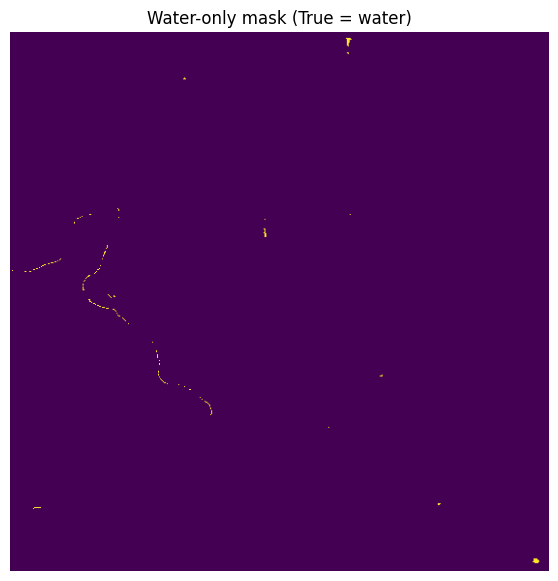

In [8]:
time_slice = 0

plt.figure(figsize=(7, 7))
plt.imshow(water_only_mask.isel(time=time_slice))
plt.title('Water-only mask (True = water)')
plt.axis('off')
plt.show()

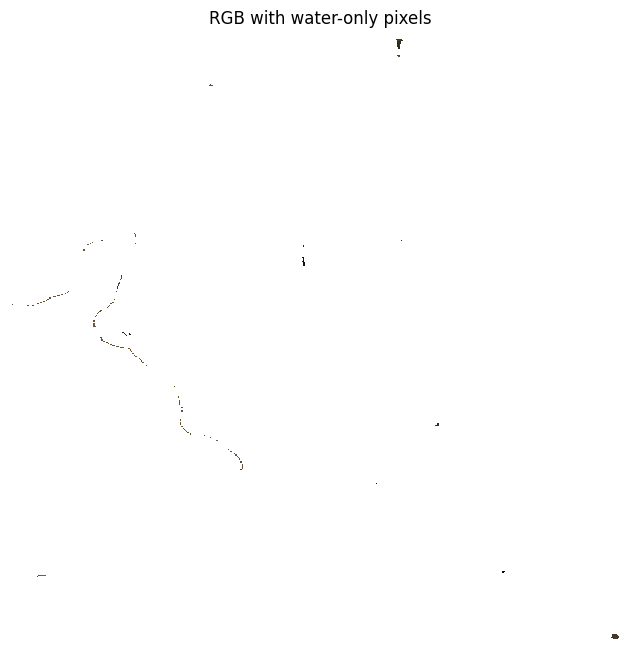

In [10]:
water_only = xx.where(water_only_mask)

fig, ax = plt.subplots(figsize=(8, 8))
water_only.isel(time=time_slice)[['red', 'green', 'blue']].to_array().plot.imshow(
    robust=True, ax=ax, vmin=0, vmax=0.3
)
ax.set_title('RGB with water-only pixels')
ax.axis('off')
plt.show()

## 7) Optional: export mask to numpy
The mask is a boolean array aligned with the Landsat grid.

In [ ]:
water_mask_np = water_only_mask.isel(time=time_slice).values
water_mask_np.shape